# Scientific Computing: Assignment Set 3
_Boyan Mihaylov (15067602)_

## 0. Imports / Preliminaries

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse.linalg as spla
import time

from importlib import reload

The module `solvers.py` contains functions for PDE solving and the module `vis_tools.py` contains visualisation functions.

In [2]:
import solvers as sv
import vis_tools as vis

## 1. Eigenmodes of Vibrating Membranes

The waves occuring in the transverse vibration of tensioned elastic membranes, such as drums, are known to resonate in specific patterns determined by the eigenmodes and eigenfrequencies of the system. These characteristics are heavily dependent on the shape of the membrane's boundary. The first experiment explores this dependence by formulating a discrete model for solving the eigenvalue problem for membranes with different boundary geometries.

The vibrations of the membrane are governed by the wave equation:

$$
\frac{\partial^2u}{\partial t^2}=c^2\nabla^2{u},\tag{1}
$$

where $u$ is the amplitude of the transverse wave and $c$ is a coefficient inherent to the material properties of the membrane.

### 1.1. Discretisation of the System

The procedure to transform this equation into an eigenvalue problem involves a separation of variables, requiring the decomposition of the amplitude into a purely space-dependent and a purely time-dependent term:

$$
u(x,y,t)=v(x,y)T(t).\tag{2}
$$

This asserted formulation can be substituted into (1), yielding the equation

$$
\frac{1}{c^2T(t)}\frac{\partial^2T(t)}{\delta{t}^2}=\frac{1}{v(x,y)}\nabla^2{v(x,y)}.\tag{3}
$$

With the $t$-dependent and the $(x,y)$-dependent variables separated in the two sides of the equation, it can be stated that the common value of the two sides is a constant, $K$. Expressing the left side through $K$ yields

$$
\frac{\partial^2T(t)}{\delta{t}^2}=Kc^2T(t),
$$

which has an oscillating solution for $K < 0$, dependent on the eigenfrequency $\lambda$:

$$
T(t) = A\cos(c\lambda t) + B\sin(c\lambda t).\tag{4}
$$

$\lambda$ is positive and real under $K\in\mathbb{R}$, as it obeys the relationship $\lambda^2=-K$. The solutions for $K=0$ and $K<0$ exhibit a static behaviour under fixed boundary conditions and an exponential growth/decay, respectively.

When the right side of (3) is expressed through $K$, it formulates the Helmholtz Equation:

$$
\nabla^2{v(x,y)}=Kv(x,y)\tag{5}.
$$

This expression is relevant for the eigenvalue problem, as it can be written in the form $\bm{M}\bm{v}=K\bm{v}$, where $\bm{v}$ is the vector of amplitudes $v(x,y)$, $K$ is a scalar constant and $\bm{M}$ is derived from the finite difference approximation of the Laplacian term:

$$
\nabla^2{v(x,y)}\approx \frac{1}{\delta{x}^2}\left[v(x+\delta{x}, y)+v(x-\delta{x},y)+v(x,y+\delta{x})+v(x,y-\delta{x})-4v(x,y)\right],
$$

assuming that $\delta{x}\equiv\delta{y}$. Representing the system through a discrete rectangular lattice of size $(N_x + 1) \times (N_y + 1)$, the matrix $\bm{M}$ is constructed from the neighbour coefficients in the finite difference scheme for the amplitude at each lattice point, $v_i$. With the total number of lattice sites written as $N_T=(N_x + 1) (N_y + 1)$, the index $i=\{0,\ldots,N_T-1\}$ follows the flattened row-wise order of the lattice elements. In a rectangular lattice, this means $i=kN_x + j$, with $j=\{0,\ldots, N_x\}, k=\{0,\ldots,N_y\}$. Respectively, the top, bottom, left and right neighbours of a lattice site can be addressed with the indices $n_1$, $n_2$, $n_3$ and $n_4$, offset from the current index depending on the boundary shape of the system. In a rectangular lattice, for each $i=kN_x + j$,

$$
n_1=(k+1)N_x + j,\\
n_2=(k-1)N_x+j,\\
n_3=kN_x+j+1\\
n_4=q,kN_x + j-1,
$$

By factoring out $1/\delta{x}^2$, Eq. (5) can be expressed as a system of linear equations:

$$
\frac{1}{\delta{x}^2}(v_{n_1}+v_{n_2}+v_{n_3}+v_{n_4}-4v_{i})=Kv_{i},
$$

which represents the row-wise operations of the eigenvalue problem $\frac{1}{\delta{x}^2}\bm{A}\bm{v}=K\bm{v}$. The left side of the equation indicates which coefficients $a_{i,q}$, $q=\{0,\ldots,N_T\}$, contained in the rows of the matrix $\bm{A}\in \mathbb{R}^{N_T \times N_T}$ to set to a non-zero value:

$$
a_{i,q}=\begin{cases}-4 & \textrm{if} \quad q=i\\ 1 & \textrm{if} \quad q \in \{n_1, n_2, n_3, n_4\} \\ 0 & \textrm{otherwise}.\end{cases}
$$

As the boundary is considered fixed, a Dirichlet boundary condition imposes a constant $v(x,y)=0$ at the edges. To prevent the boundaries from updating, all neighbour coefficients referring to boundary sites are set to zero. Conversely, each row $a_{b}$ in $\bm{A}$ relating to a boundary site contains at most one non-zero coefficient, referring to itself: $a_{b,b}=-4$

The following procedure demonstrates the construction of $\bm{M}$ from an input size $N_x\times N_y$ and visualises the indexing of the lattice as well as the resulting matrix of coefficients. In the example, the dimensions are set to $N_x=N_y=4$.

[[-4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -4.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -4.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -4.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -4.  0.  0.  0.  

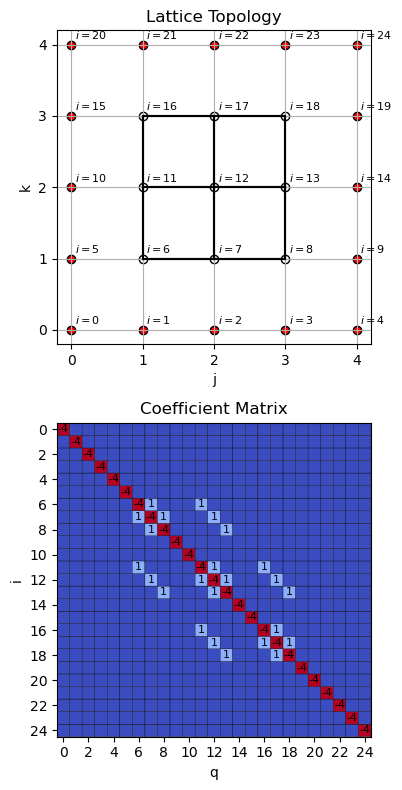

In [85]:
size_x = 5
size_y = 5

coeffs_matrix, lattice_coords = sv.construct_coeff_matrix(size_x, size_y)

print(coeffs_matrix)

# vis.plot_lattice_topology(size_x, size_y)
# vis.plot_lattice_topo_from_coeff(coeffs_matrix, lattice_coords)
# vis.plot_coeff_matrix(coeffs_matrix)
vis.plot_lattice_2D(coeffs_matrix, lattice_coords)

In the first plot above, the fixed boundary sites with $v(x,y)=0$ are shown as red dots. The thick continuous lines represent a two-way relationship in the update functions of two neighbours, whereas the lack of connections indicate that the lattice site only takes into consideration its own state in the update function. The second plot illustrates the matrix of coefficients, with the indices along each axis corresponding to $i$ in the first plot.

It is evident that the boundary sites are redundant to the coefficient matrix, as they neither become updated, nor contribute to their interior neighbours. For this reason, $\bm{A}$ can be further reduced to a matrix of size $N_R \times N_R$, $N_R = (N_x - 1)(N_y - 1)$, which only contains the coefficients of the interior sites. The following plots illustrate the resulting system.

In [73]:
reload(sv)

<module 'solvers' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 3\\solvers.py'>

[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]


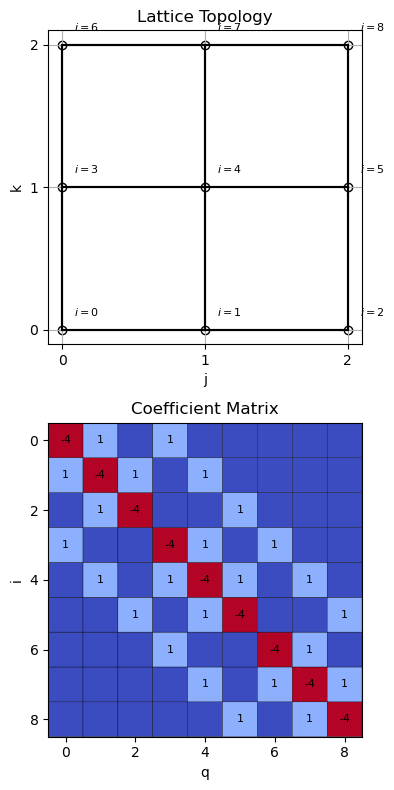

In [74]:
size_x = 5
size_y = 5

coeffs_matrix, lattice_coords, _ = sv.construct_coeff_matrix_alt(size_x, size_y)

print(coeffs_matrix)

# vis.plot_lattice_topology(size_x, size_y)
# vis.plot_lattice_topo_from_coeff(coeffs_matrix, lattice_coords)
# vis.plot_coeff_matrix(coeffs_matrix)
vis.plot_lattice_2D(coeffs_matrix, lattice_coords)

The lattice can be initiated with a rectangular or a circular boundary. In the latter case, first a rectangular lattice with size $L_x\times L_y$ is created and a circular region with a radius $R=\min{\{L_x, L_y\}}/2$ is inscribed in the centre of the lattice. The lattice indices and coordinates are then reduced to only the sites which fall within this region and the boundary sites are defined as those sites inside the circle which border to at least one site not included in the circle.

The following plots illustrate the reduced topology (excluding boundary sites) of a circle inscribed on a lattice with $N=10$ subdivisions.

In [75]:
reload(sv)

<module 'solvers' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 3\\solvers.py'>

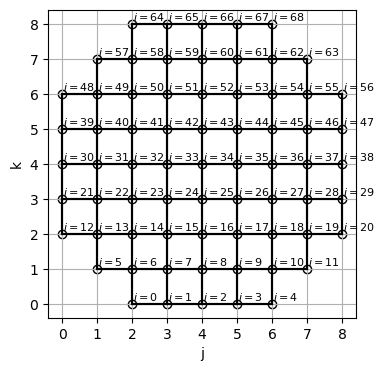

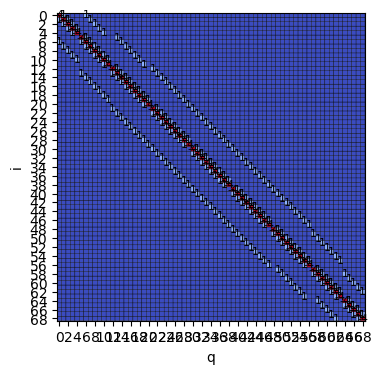

In [76]:
coeffs_matrix_circle, lattice_coords_circle, _ = sv.construct_coeff_matrix_alt(11, 11, 'circle')

vis.plot_lattice_topo_from_coeff(coeffs_matrix_circle, lattice_coords_circle)
vis.plot_coeff_matrix(coeffs_matrix_circle)

### 1.2. Comparing Methods

Three different boundary conditions are selected to exemplify the solution of the eigenvalue problem $\frac{1}{\delta{x}^2}\bm{A}\bm{v}=K\bm{v}$ under three different boundary conditions: a square, a $1:2$-ratio rectangle and a circle. To determine $\delta{x}$, a reference size measure $L$ is defined, such that $\delta{x}=L/N$, $N=\min{\{N_x, N_y\}}$. The studied boundary shapes thus have comparable sizes:
- the square has a side length $L$;
- the rectangle has side lengths $L$ and $2L$;
- the circle has a diameter $L$.

Four different eigenvalue solving methods are tested and compared in their execution speed: `scipy.linalg.eig`, `scipy.linalg.eigh`, `scipy.sparse.linalg.eigs` and `scipy.sparse.linalg.eigsh`. The first one is a general purpose solver, the second one is suited for real symmetric or Hermitian matrices. The second two are analogous to the first ones but employ sparse matrices, which are generally beneficial for matrices with a large quantity of zero elements, as they only store the nonzero ones and therefore require less storage. To provide appropriate input for these functions, the matrices are pre-converted into diagonal sparse matrices using the funcion `scipy.sparse.dia_matrix`. The difference in performance becomes visible with larger system sizes, therefore the subdivision is increased to $N=40$.

The running times for each function refer to an execution on a 2.00 GHz 13th Gen Intel(R) Core(TM) i9-13900 personal computer.

In [898]:
L = 1
N = 40
dx = 1 / N

setups = dict()
setups['names'] = ['square', 'rectangle', 'circle']
setups['shape'] = ['rect', 'rect', 'circle']
setups['N_y'] = [N, 2*N, N]
factor = L/dx**2
eigval_funcs = [la.eig, la.eigh, spla.eigs, spla.eigsh]

# DataFrame for storing the results
results_method = pd.DataFrame(columns=[''] + setups['names'])

# Loop over the different eigval functions
for func in eigval_funcs:

    if func in [spla.eigs, spla.eigsh]:
        sparse = True
    else:
        sparse = False
    
    results_row = pd.DataFrame(dict(zip([''] + setups['names'],
                                        [[func.__name__ + str(" time"), func.__name__ + str(" $\lambda_{min}$")],
                                         [None, None],[None, None],[None, None]])))
    # Loop over the different setups
    for name, shape, N_y in zip(setups['names'], setups['shape'], setups['N_y']):
        coeffs_matrix, _, _ = sv.construct_coeff_matrix_alt(N, N_y, shape, sparse)
        start_time = time.time()
        eigvals, eigvecs = sv.solve_eigval_problem(coeffs_matrix, factor, func)
        end_time = time.time()
        time_elapsed = end_time - start_time
        results_row[name].iloc[0] = time_elapsed
        results_row[name].iloc[1] = float(eigvals[np.argsort(np.abs(eigvals))][0])
    
    results_method = pd.concat([results_method, results_row], axis=0)

results_method

C:\Users\mihbo\AppData\Local\Temp\ipykernel_19472\1632308147.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  results_row[name].iloc[1] = float(eigvals[np.argsort(np.abs(eigvals))][0])


,,square,rectangle,circle
0,eig time,0.606113,3.536861,0.400453
1,eig $\lambda_{min}$,-20.753228,-12.906543,-24.284445
0,eigh time,0.476106,1.343639,0.328404
1,eigh $\lambda_{min}$,-20.753228,-12.906543,-24.284445
0,eigs time,0.03357,0.098728,0.017201
1,eigs $\lambda_{min}$,-20.753228,-12.906543,-24.284445
0,eigsh time,0.027958,0.059622,0.016188
1,eigsh $\lambda_{min}$,-20.753228,-12.906543,-24.284445


In [228]:
results_method.to_latex('results_eigval_method.tex', index=False)

The results show a clear reduction in computation time for all boundary shapes when a more specialised method (`scipy.linalg.eigh`, `scipy.sparse.linalg.eigsh`) is used instead of its general purpose counterpart. This is to be expected, since the provided matrices are real symmetric and can benefit from the functionality of these methods. A difference of an entire order is visible when switching from a dense-matrix method to a sparse-matrix method. This is an obvious result from the reduction of computations achieved by sparse matrix systems. By retrieving the smallest eigenvalue calculated by each method it can be shown there is no significant difference in the computed results for this specific case.

### 1.3. Finding the Eigenmodes

Having established the superiority of specialised sparse-matrix methods in solving the eigenvalue problem efficiently, the eigenspectrum of the three systems is examined in more detail, using the method `scipy.sparse.linalg.eigsh`. The method is set up to return the 6 smallest eigenvalues (eigenfrequencies) and their corresponding eigenvectors (eigenmodes). The modes are visualised as colour values in the membrane domain, with an indication of their corresponding frequency $K$.

In [899]:
# Eigenvalue problem solver
eigval_func = spla.eigsh

eigvals_shapes = []
eigvecs_shapes = []
lattice_coords_shapes = []

# Loop over the different setups
for name, shape, N_y in zip(setups['names'], setups['shape'], setups['N_y']):
    coeffs_matrix, lattice_coords, _ = sv.construct_coeff_matrix_alt(N, N_y, shape, True)
    eigvals, eigvecs = sv.solve_eigval_problem(coeffs_matrix, factor, eigval_func)
    lattice_coords_shapes.append(lattice_coords)
    eigvals_shapes.append(eigvals[-6:].astype(float))
    eigvecs_shapes.append(eigvecs[-6:])

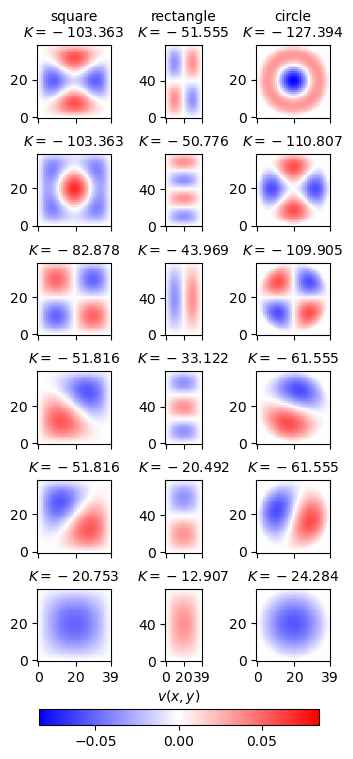

In [900]:
vis.plot_eigmodes_spectrum(eigvecs_shapes, eigvals_shapes, lattice_coords_shapes, setups['names'])

### 1.4. Influence of $L$ and $N$

Beside the boundary shape, there are two numerical factors determining the setup of the system. One is the size measure $L$ and the other one is the number of subdivisions $N$ per length $L$. As they conjointly determine the factor of multiplication for $\bm{A}$, $\frac{1}{\delta{x}^2}$, their influence is to be examined separately, by fixing either parameter and varying the other. The changes in the eigenvalue spectrum are then observed, in particular the 6 smallest eigenvalues. Beside its influence on $\delta{x}$, $N$ also defines the size of the coefficient matrix, the number of eigenvalues and the granularity of the lattice domain. It is therefore relevant to observe how the resulting eigenvalue range (smallest vs. largest eigenvalue) changes with varying $N$.

The experimental setup for this study uses the same boundary shapes as before but alters their size parameters. For the study of $L$, the vector of eigenvalues is saved for each incremental increase of $L$ from $0.5$ to $10$, with $N=8$ (resulting in $6\times 6$ non-boundary sites in the square case). The stored vectors are subsequently visualised in a three-dimensional surface plot. For the study of $N$, $L$ is kept at $1$ and $N$ is increased from $5$ to $100$. The largest and the smallest eigenvalues are saved at each step and finally plotted.

In [79]:
# Simulation setup
Ls = np.linspace(0.5, 1000, 2000)
N = 8
setups['N_y'] = [N, 2*N, N]
eigval_func = spla.eigsh

# Variables for storing simulation results
result_setups = pd.DataFrame(columns=['Boundary', 'L'])
result_eigvals = np.empty((len(Ls), len(setups['names']), 6))

# Loop over the different setups
for i, L in enumerate(Ls):
    dx = L / N
    factor = 1/dx**2
    for j, (name, shape, N_y) in enumerate(zip(setups['names'], setups['shape'], setups['N_y'])):
        coeffs_matrix, _, _ = sv.construct_coeff_matrix_alt(N, N_y, shape, True)
        eigvals, _ = sv.solve_eigval_problem(coeffs_matrix, factor, eigval_func)
        result_setups = pd.concat([result_setups, pd.DataFrame({'Boundary': [name], 'L': [L]})], axis=0)
        result_eigvals[i, j] = eigvals

result_eigvals = result_eigvals.reshape(-1, 6)

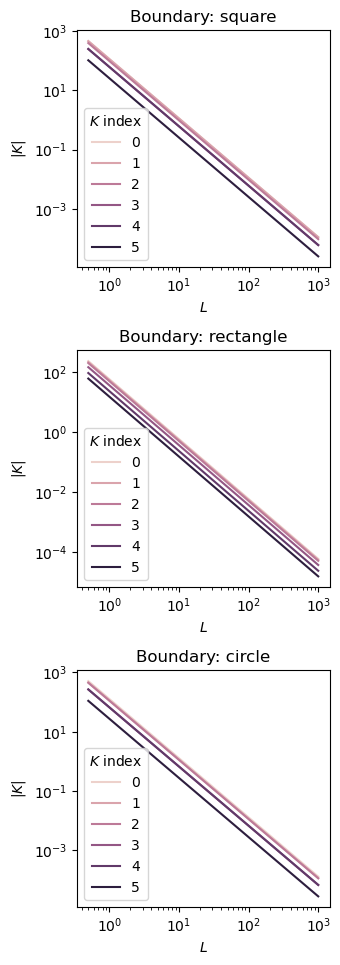

In [232]:
vis.plot_eigvals_Ls(result_setups, result_eigvals)

The straight lines in the log-log plots of $L$ vs. $|K|$ clearly indicate an exponential decrease in the eigenvalues with increasing $L$.

In [80]:
# Simulation setup
L = 1
Ns = np.arange(5, 105, 5)

# Variables for storing simulation results
result_setups = pd.DataFrame(columns=['Boundary', 'N'])
result_eigvals = np.empty((len(Ns), len(setups['names']), 2))

# Loop over the different setups
for i, N in enumerate(Ns):
    dx = L / N
    factor = 1/dx**2
    setups['N_y'] = [N, 2*N, N]
    for j, (name, shape, N_y) in enumerate(zip(setups['names'], setups['shape'], setups['N_y'])):
        coeffs_matrix, _, _ = sv.construct_coeff_matrix_alt(N, N_y, shape, True)
        eigvals, _ = sv.solve_eigval_problem(coeffs_matrix, factor, eigval_func, both_ends=True)
        result_setups = pd.concat([result_setups, pd.DataFrame({'Boundary': [name], 'N': [N]})], axis=0)
        result_eigvals[i, j] = [np.min(eigvals), np.max(eigvals)]

result_eigvals = result_eigvals.reshape(-1, 2)

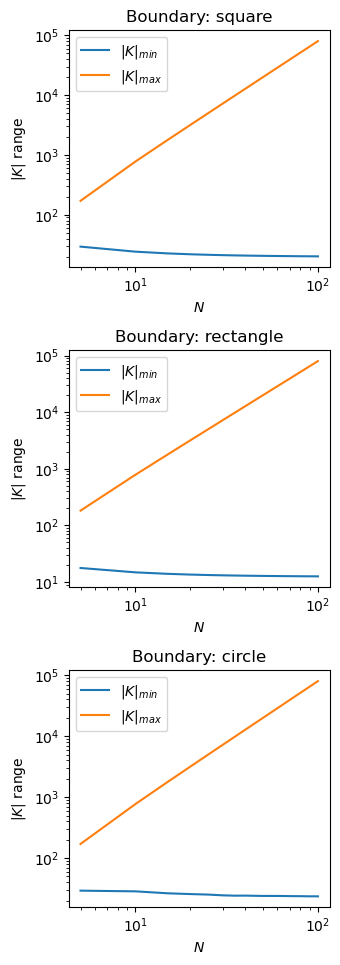

In [16]:
vis.plot_eigvals_Ns(result_setups, result_eigvals)

Observing the upper bounds of the eigenspectrum, the plots indicate a seemingly exponential increase in the largest $|K|$ values with increasing $N$ for all boundary shapes. Contrarily, the lower bounds of the eigenspectrum appear to converge to an asymptotic value with increasing $N$.

### 1.5. Time-dependent Solutions

The identified eigenfrequencies for the systems with $L=1, N=40$ can be used in simulating the time-dependent oscillation of a membrane's eigenmodes, by using $K$ to define the $\lambda$ parameter in Eq. (4) and hence the time-dependent term $T(t)$ in Eq. (2). Eq (2) contains two parameters, $A$ and $B$, which can be derived from an initial condition, $u(x,y,0)$, and its time derivative $u_t(x,y,0)$. At $t=0$,

$$
T(0)=A\cos{c\lambda 0}+B\sin{c\lambda 0} = A,
$$

$$
T'(0)=-Ac\lambda\sin{c\lambda 0}+Bc\lambda\cos{c\lambda 0} = Bc\lambda.
$$

The initial condition thus becomes:

$$
u(x,y,0)=v(x,y)A
$$

$$
u_t(x,y,0)=v(x,y)Bc\lambda
$$

Since $A$ and $B$ are scalars, it follows that $u(x,y,0)\propto v(x,y)$ and $u_t(x,y,0)\propto v(x,y)$, meaning that the initial excitation of the membrane contains scaled versions of the eigenmodes. $A$ and $B$ are generally different for each eigenmode of the system, consistent with the fact that a different initial perturbation of the membrane can yield the activation of eigenmodes with different amplifications.

The momentary displacement vector of a membrane, $\bm{u}(t)$, and its velocity vector, $\bm{u'}(t)$, can be represented as a superposition of scaled eigenmodes. An arbitrary initial configuration therefore also exists in this eigenspace and can be decomposed into such a sum. $A$ and $B$ can be retrieved through a projection of the initial displacement or velocity vector onto a specific eigenvector $\bm{v}$, by computing the dot products:

$$
A=\bm{u}(0)\cdot\bm{v}
$$

$$
B=\frac{1}{c\lambda}\bm{u'}(0)\cdot\bm{v}
$$

To simulate a localised excitation of the membrane (e.g. hitting a drum with a drum stick), a 2D Gaussian function is used to define the initial state of the membrane:

$$
\bm{u}(0)=he^{-\frac{1}{2}(\bm{x}-\bm{x_0})^T\Sigma^{-1}(\bm{x}-\bm{x_0})},
$$

$$
\bm{u'}(0)=ae^{-\frac{1}{2}(\bm{x}-\bm{x_0})^T\Sigma^{-1}(\bm{x}-\bm{x_0})},
$$

where $h$ determines the height of the Gaussian function of the displacement, $a$ scales the Gaussian function of the starting velocity, $\bm{x}$ is the positional vector on the membrane surface and $\bm{x_0}$ defines the peak position of the functions. $\Sigma$ is a covariance matrix constructed as

$$
\Sigma=\begin{bmatrix}
\sigma^2 & 0\\
0 & \sigma^2
\end{bmatrix},
$$

where $\sigma$ is a parameter controlling the width of the impulse.

Three initial excitations are tested. The first one represents a sharp centered impulse with an equal magnitude of displacement and velocity: $\bm{x_0}=(L/2,L/2)$, $h=-0.1$, $a=-0.1$, $\sigma=0.5$. The second one represents another centered impulse with a velocity of half the magnitude of the displacement and a wider spread: $\bm{x_0}=(L/2,L/2)$, $h=-0.2$, $a=-0.1$, $\sigma=2$. The third one represents an eccentric sharp impulse with a velocity twice as large as the displacement: $\bm{x_0}=(L/4,L/4)$, $h=-0.1$, $a=-0.2$, $\sigma=0.5$. The material coefficient $c$ is set to 1 for convenience. All 6 lowest eigenvalue and their corresponding eigenvectors are examined. The intermediate solutions are presented in temporal snapshots as well as a series of animated plots.

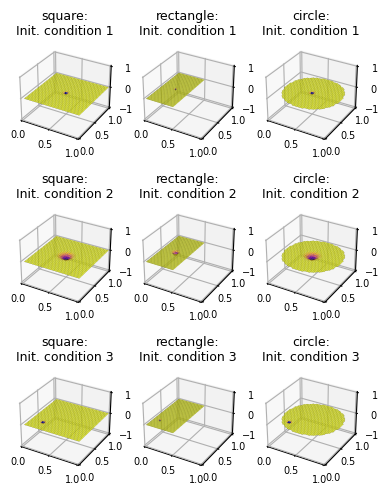

In [902]:
# Simulation setup
L = 1
N = 40
dx = 1 / N
N_ys = [N, 2*N, N]

ts = np.linspace(0, 1, 101)

# Initial condition parameters
h_s = [-0.1, -0.2, -0.1]
a_s = [-0.1, -0.1, -0.2]
sigmas = [0.5, 2, 0.5]

init_amps = []
init_vels = []
for i in range(len(setups['names'])):
    x0s = [np.array(((N-2)//2,(N_ys[i]-2)//2)), np.array(((N-2)//2,(N_ys[i]-2)//2)), np.array(((N-2)//4,(N_ys[i]-2)//4))]
    init_amps_bndry = np.empty((3, lattice_coords_shapes[i].shape[0]))
    init_vels_bndry = np.empty((3, lattice_coords_shapes[i].shape[0]))
    for j in range(3):
        init_amps_bndry[j] = sv.construct_init_condition_gaussian(h_s[j], x0s[j], sigmas[j], lattice_coords_shapes[i])
        init_vels_bndry[j] = sv.construct_init_condition_gaussian(a_s[j], x0s[j], sigmas[j], lattice_coords_shapes[i])
        # vis.plot_init_condition(lattice_coords_shapes[i], init_amps_bndry[j])
    init_amps.append(init_amps_bndry)
    init_vels.append(init_vels_bndry)

vis.plot_init_condition_3D_multiple(lattice_coords_shapes, init_amps, setups['names'])

In [903]:
eigvecs_selection = [ev[3:] for ev in eigvecs_shapes]
eigvals_selection = [ev[3:] for ev in eigvals_shapes]

u_evolutions_A = sv.compute_wave_time_dependent_multiple([ia[0] for ia in init_amps], [iv[0] for iv in init_vels], eigvecs_selection, eigvals_selection, ts)
u_evolutions_B = sv.compute_wave_time_dependent_multiple([ia[1] for ia in init_amps], [iv[1] for iv in init_vels], eigvecs_selection, eigvals_selection, ts)
u_evolutions_C = sv.compute_wave_time_dependent_multiple([ia[2] for ia in init_amps], [iv[2] for iv in init_vels], eigvecs_selection, eigvals_selection, ts)

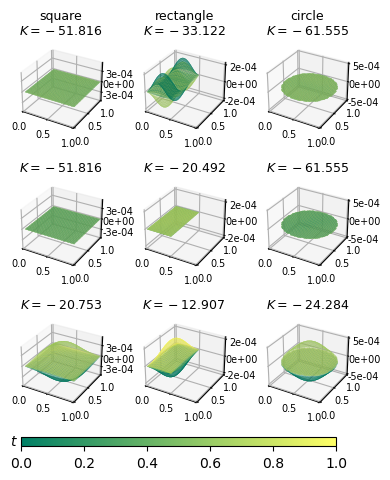

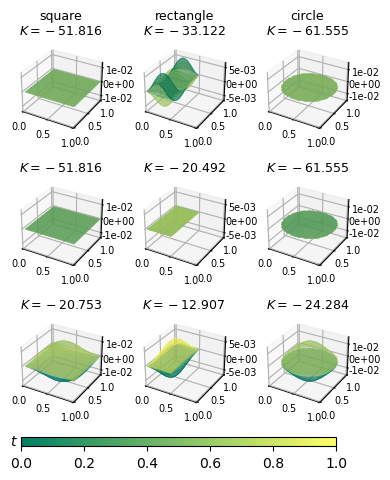

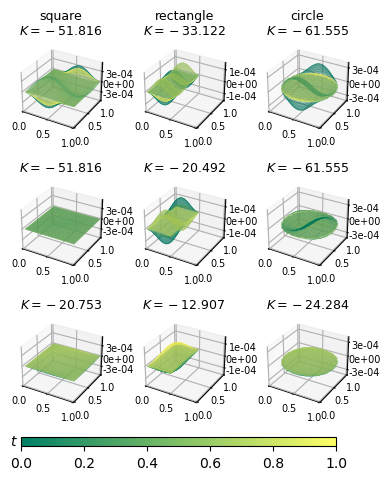

In [904]:
ts_selection = ts[np.array((0, len(ts)//3, 2*len(ts)//3, -1)).T]

vis.plot_time_dependent_solutions(u_evolutions_A, ts_selection, lattice_coords_shapes, setups['names'], eigvals_selection, ts)
vis.plot_time_dependent_solutions(u_evolutions_B, ts_selection, lattice_coords_shapes, setups['names'], eigvals_selection, ts)
vis.plot_time_dependent_solutions(u_evolutions_C, ts_selection, lattice_coords_shapes, setups['names'], eigvals_selection, ts)

The animation below provides a more informative view of the vibrations of the eigenmode vibrations for the six smallest in magnitude eigenvalues. In the rightmost column of the animation, the six eigenmodes are summed to partially approximate the total displacement of the membrane at the specified time points.

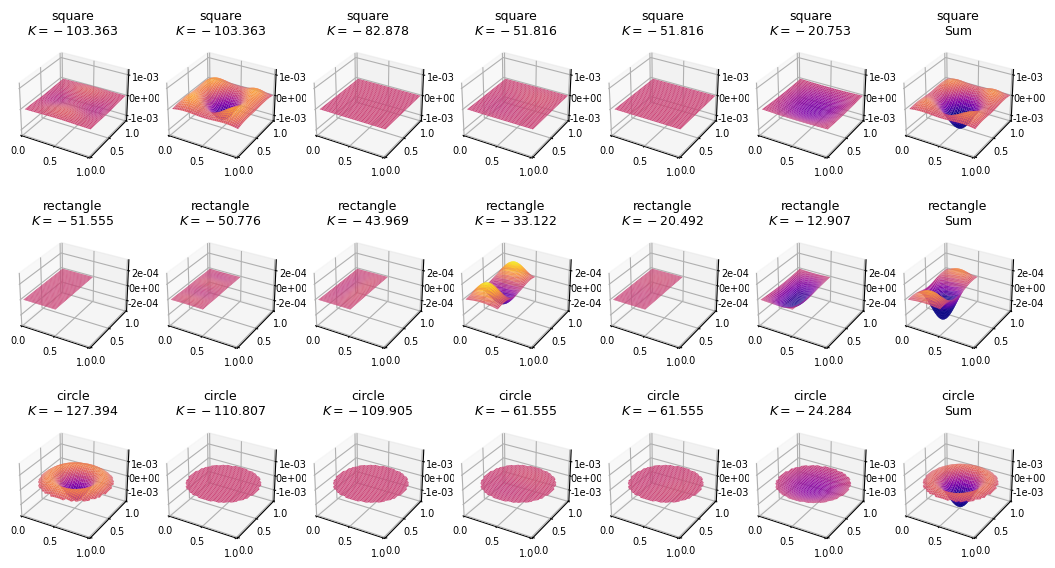

In [905]:
u_evolutions_A = sv.compute_wave_time_dependent_multiple([ia[0] for ia in init_amps], [iv[0] for iv in init_vels], eigvecs_shapes, eigvals_shapes, ts)
vis.animate_membranes(u_evolutions_A, lattice_coords_shapes, setups['names'], eigvals_shapes, ts, "Initial condition 1")

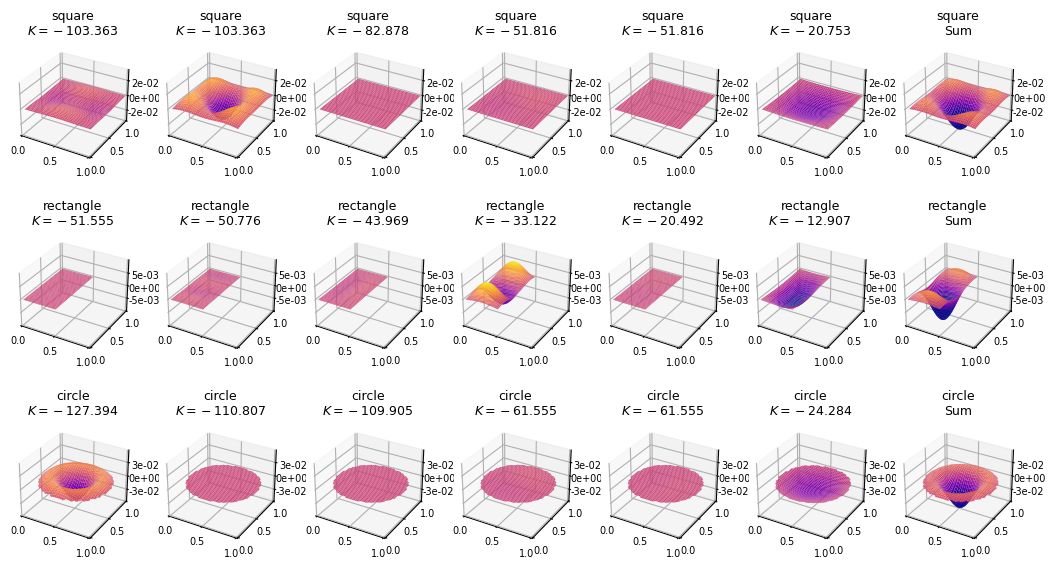

In [906]:
u_evolutions_B = sv.compute_wave_time_dependent_multiple([ia[1] for ia in init_amps], [iv[1] for iv in init_vels], eigvecs_shapes, eigvals_shapes, ts)
vis.animate_membranes(u_evolutions_B, lattice_coords_shapes, setups['names'], eigvals_shapes, ts, "Initial condition 2")

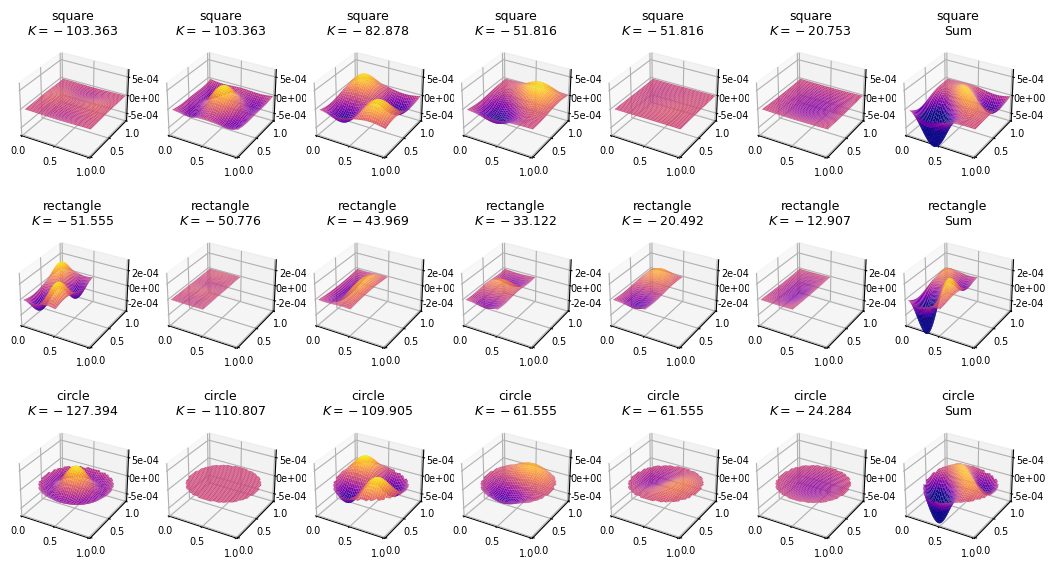

In [907]:
u_evolutions_C = sv.compute_wave_time_dependent_multiple([ia[2] for ia in init_amps], [iv[2] for iv in init_vels], eigvecs_shapes, eigvals_shapes, ts)
vis.animate_membranes(u_evolutions_C, lattice_coords_shapes, setups['names'], eigvals_shapes, ts, "Initial condition 3")

An examination of the first two initial conditions shows a little difference in the qualitative behaviour of the vibrations, with only the radially symmetrical eigenmodes becoming enhanced, the rest remaining attenuated. A closer look at the amplitude ranges reveals that the second, more spread out impulse is causing vibrations lower in amplitude than the first one. The third case exhibits qualitatively different activation pattern among the eigenmodes. Some of the radially symmetrical eigenmodes are amplified, but a stronger displacement is noticeable in the more complex eigenmodes, which oscillate asymmetrically within the membrane domain.

A qualitative evaluation of the observed plots and animations leads to the indication that the coincidence of the perturbation region of the initial condition and the high-amplitude regions of specific eigenmodes may cause these eigenmodes to become more pronounced in the resulting vibration. For instance, the centered initial conditions appear to activate the eigenmodes with centered patterns, while the eccentric perturbation tends to trigger patterns with eccentric regions.

## 2. Direct Method for Solving the Diffusion Equation

A matrix-based approach can also be applied as a direct method for solving the diffusion equation

$$
\frac{\partial c}{\partial t}=D\nabla^2c.\tag{2}
$$

on a two-dimensional domain analogous to the one for computing the wave eigenspectrum. The variable $c(t,x,y)$ represents the local concentration over time $t$ and space $(x,y)$. In many applications, it suffices to find a solution for the steady state of the system, i.e. when the concentrations are no longer dependent on time. The system is then solely governed by the Laplace equation $\nabla^2c=0$, which can be discretised using the following finite difference scheme:

$$
c_{j+1,k}+c_{j-1,k}+c_{j,k+1}+c_{j,k-1}-4c_{i,j}=0,
$$

with $j=\{1,\ldots, N_x-1\}, k=\{1,\ldots,N_y-1\}$. This equation can also be represented as coefficients in a matrix $\bm{M}=\frac{1}{4}\bm{A}$ ($\bm{A}, \bm{M}\in \mathbb{R}^{N_R\times N_R}$), using the exact same procedure as with the two-dimensional wave equation.

A special case arises when one or more of the lattice site neighbours belong to a fixed boundary condition. If a neighbour index $\beta \in B=\set{n_k, \, k=1,\dots,4 \, \mid \, c_{n_k}=\textrm{const}}$, the boundary condition value can be shifted to the right side of the equation, yielding

$$
\sum_{n \notin B}{c_n}=-\sum_{\beta}c_\beta.
$$

This way the boundary condition can be integrated in the right-side vector $\bm{b}$ of the linear system $\bm{M}\bm{c}=\bm{b}$. This system can then be solved using the `scipy.linalg.solve` method.

The previous procedure for constructing the coefficient matrix is therefore extended to also return $\bm{b}$, in which each element $b_i$ is formed by the negated sum of source or sink boundary neighbour concentrations. If such neighbours are not present, $b_i=0$. For the current experiment, the boundary condition includes a circular edge with radius $r=2$, centered at the origin, on and beyond which $c=0$. The corresponding $b_i$-s are therefore also set to zero. Additionally, a constant source point is introduced at the coordinates $(0.6, 1.2)$, assigning a constant $c=1$ to one of the lattice sites. This site needs to be removed from the coefficient matrix as to not be updated, and its coefficient as a neighbour of other sites is set to $c_\beta=1$ for the calculation of $\bm{b}$.

In [9]:
R = 2
L = 2 * R
N = 160

src_pt = np.array((0.6, 1.6)) + np.array((R, R))
src_idx = (src_pt * (N  - 1) / L).astype(int)

coeff_matrix, lattice_coords, b_vector = sv.construct_coeff_matrix_alt(N, N, 'circle', True, tuple(src_idx))

sol = spla.spsolve(coeff_matrix, b_vector)

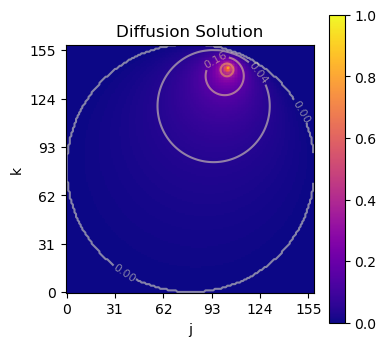

In [44]:
vis.plot_diff_eq_solution(sol, lattice_coords, src_idx)

The visualisation illustrates a sharp localised peak around the source point, around which the concentrations quickly dissipate to very low values. The level curves of the concentrations are circles, indicating that the concentrations are equal at the same fraction of the distance between the source point and the circular boundary.

## 3. The Leapfrog Method

While direct methods facilitate solving explicit, forward-marching finite difference schemes, such schemes remain only conditionally stable and are prone to larger errors, since they are limited to first-order differences. Implicit methods can alleviate this issue, but at the cost of more complex calculations. A compromise can be found for specific problems which involve two ODEs which are not dependent on themselves but only on each other. Such problems include dynamical systems of motion, containing the variables for position ($x$), velocity ($v$) and force ($F$). In these cases, the Leapfrog method can be applied to achieve higher order convergence and better stability.

### 3.1. Application on a Harmonic Oscillator


The method is illustrated on the example case of a simple harmonic oscillator. This one-dimensional system is described by the second-order ODE

$$
m\frac{d^2x}{dt^2}+kx=0,
$$

where $m$ is the mass of the oscillating object and $k$ is a positive spring constant. Rewriting this equation as a force term, one arrives at Hooke's law:

$$
F(x)=m\frac{d^2x}{dt^2}=m\frac{dv}{dt}=-kx.
$$

This second-order ODE can thus be easily solved if decomposed into two first-order ODEs:

$$
\frac{dx}{dt}=v
$$

$$
\frac{dv}{dt}=-\frac{k}{m}x
$$

A standard forward Euler scheme discretizes the above equation through a first-order finite difference:

$$
\frac{x_{n+1}-x_{n}}{\delta{t}}=v_n
$$

$$
\frac{v_{n+1}-v_{n}}{\delta{t}}=-\frac{k}{m}x_n
$$

The Leapfrog method makes use of the fact that the derivatives are not directly dependent on their corresponding variables, and updates the variables $x$ and $v$ by integrating their ODEs sequentially, offset by a half-step:

$$
\frac{x_{n+1}-x_{n}}{\delta{t}}=v_{n+1/2}
$$

$$
\frac{v_{n+3/2}-v_{n+1/2}}{\delta{t}}=-k\frac{x_{n+1}}{m}
$$

It can be observed that there are three steps present in each equation - a central step ($n$ in the first equation and $n+1/2$ in the second), one half-step before it and one after. This is evidence for a centered difference scheme, which is known to be second-order accurate. Rewriting the above equations yields the update functions:

$$
x_{n+1}=x_n+\delta{t}v_{n+1/2}
$$

$$
v_{n+3/2}=v_{n+1/2}-\frac{k\delta{t}}{m}x_{n+1}
$$

The question remains how to calculate the initial half-step of the $v$ variable. A logical choice would be to perform a single forward Euler iteration with the initial position and velocity, using a halved time step:

$$
v_{1/2}=v_{0}-\frac{k\delta{t}}{2m}x_0
$$

This iteration is first-order accurate, but is only performed once, so it doesn't have a significant effect on the accuracy of the integration. Similarly, to re-align the temporal velocity grid with the positions (e.g. for plotting synchronous results), another half-way Euler forward iteration can be implemented upon demand:

$$
v_{n}=v_{n-1/2}-\frac{k\delta{t}}{2m}x_n
$$

The Leapfrog method is first demonstrated under an initial condition $x_0=1$ and $v_0=0$ (static displacement with no initial velocity), exploring the effect of the spring constant $k$ by varying its value from $0.1$ to $10$. The results are plotted in combined plots of the time series and the phase plot of $x(t)$ and $v(t)$. The mass $m$ is set to zero for convenience and the time step is set to $\delta{t}=0.1$.

In [813]:
# Simulation setup
x0 = 1
v0 = 0
t_max = 20
ks = np.array([0.1, 1, 10])
dt = 0.1

xs = np.empty((len(ks), int(np.floor(t_max / dt))))
vs = np.empty((len(ks), int(np.floor(t_max / dt))))
ts = np.empty((len(ks), int(np.floor(t_max / dt))))

for i, k in enumerate(ks):
    xs[i], vs[i], ts[i] = sv.compute_harmonic_oscillator_leapfrog(x0, v0, t_max, k, dt=dt)

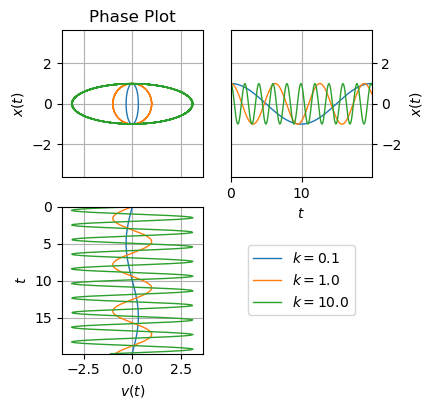

In [814]:
vis.plot_harmonic_oscillator(xs, vs, ts, ks)

The phase plot illustrates the influence of $k$ parameter on the vibrating behaviour. For $k=0.1$ the oscillations have a long period and low velocity peaks compared to the displacement. For $k=1$ the velocity and displacement peaks are equal, resulting in a circular phase plot. For $k=10$ the relationship has reversed and the spring oscillates with a high frequency and high peak amplitudes compared to the displacement.

These results indicate the role of $k$ for quantifying the spring stiffness: smaller $k$ values are representative of a loose spring which slowly moves up and down; larger values of $k$ simulate the high-frequency oscillations of a tight spring, being pulled towards its equilibrium point with a greater velocity.

### 3.2. Comparison with _RK45_

The Leapfrog method is a symplectic integrator, which makes it very suitable for modelling Hamiltonian systems, as the energy obtained from the integration results is conserved for very long simulation times. The total energy of an undamped harmonic oscillator can be calculated from the kinetic and potential energies as follows:

$$
E_{T} = \frac{1}{2} kx^2 + \frac{1}{2} mv^2
$$

This property of the Leapfrog algorithm makes it a preferable choice in this case, even compared to more sophisticated methods with higher-order accuracy, such as the Runge-Kutta-Fehlberg method (RK45). To illustrate this symplectic behaviour, the Leapfrog implementation is compared to the RK45 implementation in `scipy.integrate.RK45` by integrating the motion of a harmonic oscillator with $k=1$, initial conditions $x_0=1$ and $v_0=0$ and a time interval $\delta{t}=0.1$. The RK45 method is implemented without an adaptive step, constraining $\delta{t}$ to the same value as the Leapfrog implementation for better comparison. The energies are computed at each integration step until $t_{max}=10^4$ and visualised in a comparative plot.

Additionally, the two methods are compared in their error with regard to the analytical solution of the system: $x(t)=cos(\omega t)$, where $\omega=\sqrt{\frac{k}{m}}$. The error $\epsilon$ is expressed as the absolute difference between the numerical and the analytical solution. This enables the observation of the two methods in the context of their performance.

In [815]:
# Simulation setup
x0 = 1
v0 = 0
t_max = 100000
k = 1
dt = 0.1

xs1, vs1, ts1 = sv.compute_harmonic_oscillator_leapfrog(x0, v0, t_max, k, dt=dt)
xs2, vs2, ts2 = sv.compute_harmonic_oscillator_rk45(x0, v0, t_max, k, dt=dt)

In [817]:
reload(vis)

<module 'vis_tools' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 3\\vis_tools.py'>

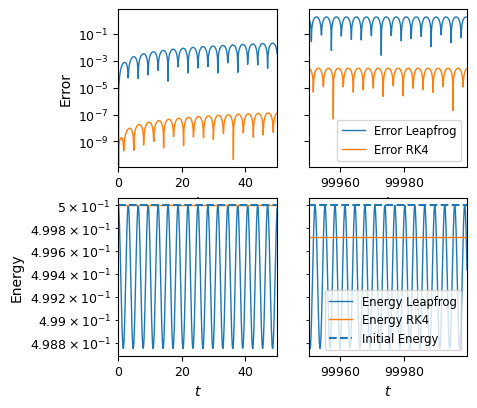

In [818]:
vis.plot_leapfrog_rk45_comparison(xs1, vs1, xs2, vs2, ts1, last=500)

Even though a larger error is consistently observable both in the early and the late integration steps of the Leapfrog method, the energy plots indicate that eventually the RK45 method drops below the baseline energy calculated at the beginning of the simulation, while the energy from the Leapfrog method oscillates in a consistent relationship to the baseline. From this it can be concluded that a preservation of the mean energy is present in the Leapfrog method.

### 3.3. External Drive on the Harmonic Oscillator

To test the behaviour of the Leapfrog method on a more sophisticated dynamic system, an external driving force can be introduced which oscillates in a sinusoidal fashion. The governing equation then becomes

$$
m\frac{d^2x}{dt^2}+kx-F_D(t)=0,
$$

where $F_D(t)=\cos{(\omega_D t + \phi)}$ is the oscillating external force with frequency $\omega_D$ and phase $\phi$. The velocity derivative thereby becomes

$$
\frac{dv}{dt}=\frac{F_D(t)-kx}{m}.
$$

The experiment carried out with this system explores how the frequency $\omega_D$ affects the motion of the oscillator. In particular, it is interesting to examine values close to the natural frequency of the oscillator, $\omega$. In the simple case when $k=1$ and $m=1$, $\omega=1$. The experimental setup again includes $\omega_D$ values varying exponentially from $0.1$ to $10$, this time presenting more samples in a larger phase plot.

In [868]:
# Simulation setup
x0 = 1
v0 = 0
t_max = 200
k = 1
dt = 0.1

# omegas = 10 ** np.linspace(-1, 1, 5)
omegas = np.linspace(0.5, 2.25, 8)

xs = np.empty((len(omegas), int(np.floor(t_max / dt))))
vs = np.empty((len(omegas), int(np.floor(t_max / dt))))
ts = np.empty((len(omegas), int(np.floor(t_max / dt))))

for i, omega in enumerate(omegas):
    xs[i], vs[i], ts[i] = sv.compute_harmonic_oscillator_leapfrog(x0, v0, t_max, k, dt=dt, omega=omega)

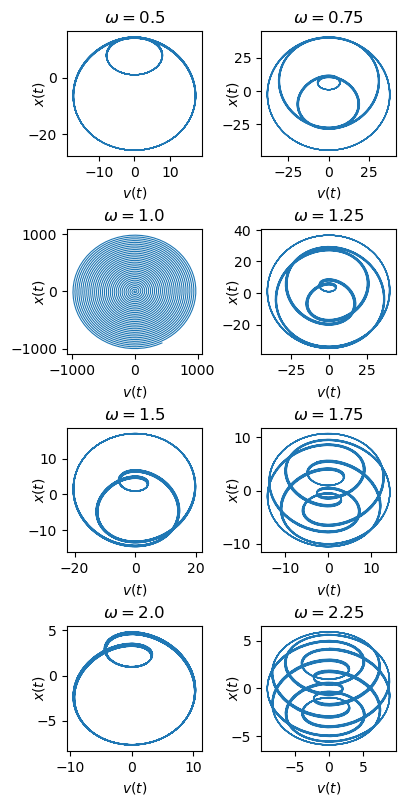

In [897]:
vis.phase_plots(xs, vs, omegas)